In [1]:
# First we need to import all the necessary toolboxes...
from scipy.optimize import fsolve 
from scipy.interpolate import interp1d
# import all the standard math functions and plotting stuff we'd want from numpy and matplotlib
from numpy import*
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline 
import pandas as pd

# Chapter 6/7: Convective flow over a flat plate
An aluminum, cylindrical, heating element (D = 10 mm) is installed in a duct with air flowing over it in cross flow at 27 $^o$C and 10 m/s. 

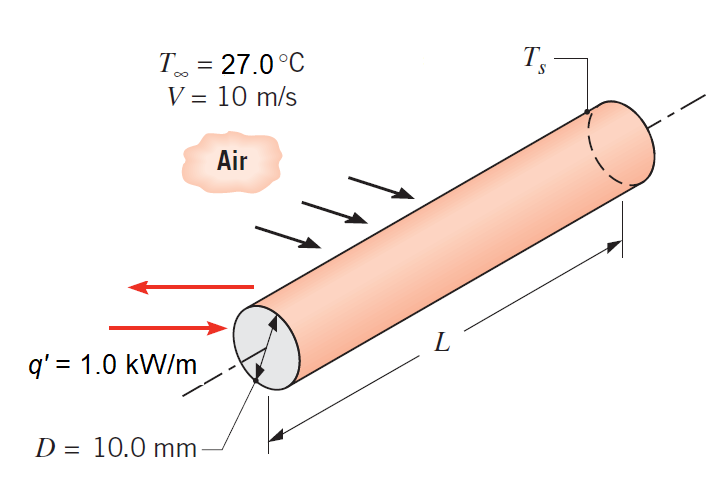

Neglecting radiation, you are asked to:
- (a) Estimate the steady-state surface temperature per unit length of the heater if q' = 1.0 kW/m 
- (b) If the heater starts at a temperature of 27 $^o$C, estimate the time required to come within 10 $^o$C of the steady-state value.

### Assumptions:
- 1-D flow over a cylinder in cross-flow ($L$ = 1.0 m)
- constant properties (i.e., $k$'s)
- constant heat flux through the rod
- no radiation
- uniform cylinder surface temperature (i.e., at a given time)

### Analysis:
#### Part(a): steady-state
For the steady state surface temperature, we can utilize a basic surface energy balance to determine the surface temperature:

$$
h \pi D \left(T_s - T_\infty\right) = h \frac{A_s}{L} \left(T_s - T_\infty\right) = q'L
$$

...where the only unknown is the convective heat transfer coeff, $h$. To determine this we can use one of several correlations. For all of them, however we'll need to calculate some fluid properties. Given that many (most?) correlations utilzie the film temperature ($T_f$) to find these, that's what we'll do here ... BUT, we need to guess a film temp, so let's guess that the final surface temp will be ~600 K, which yields a film temp of $T_f$ = 450 K. We can now use this film temp to calculate the viscosity ($\nu$), the Prandtl Number (Pr), and the thermal conductivity ($k$).

For all of these, we'll also need to find the Re$_D$ = $\frac{V D}{\nu}$ = 3087 (... which is laminar since < 2x10$^5$

- Options 1: Zukauskas
$$
Nu = \frac{h D}{k_{air}} = C  Re_D^m  Pr^n \left(\frac{Pr}{Pr_s}\right)^{1/4}
$$
...where for the given Re$_D$, $C$ = 0.26, $m$ = 0.6, and Pr$_s$ is the Pr evaluated at $T_s$

- Options 2: Hilpert
$$
Nu = \frac{h D}{k_{air}} = C  Re_D^m  Pr^{1/3}
$$
...where for the given Re$_D$, $C$ = 0.683 and $m$ = 0.466

- Options 1: Churchill and Bernstein
$$
Nu = \frac{h D}{k_{air}} = 0.3 + \frac{0.62 Re_D^{1/2} Pr^{1/3}}{\left[1+\left(0.4/Pr\right)^{2/3}\right]^{1/4}}\left[1+\left(\frac{Re_D}{282,000}\right)^{5/8}\right]^{4/5}
$$

#### Part (b): transient
For the transient case, we want to check the Biot number to see if we can use the lumped-capacitance method:

$$
Bi_D = \frac{hL_c}{k} = \frac{h \left(\frac{r}{2}\right)}{k_{Al}}  = 0.0011 << 0.1
$$

Since the Bi is less than 0.1, we can use lumped capacitance, but we need to use the general method due to the presence of internal energy generation.

The resulting temperature solution is:

$$
T(t) - 273 = T_\infty + (T_i - T_\infty) * \exp(-a * t) + (b / a) * \left(1 - \exp(-a * t)\right)
$$

where $a = (h * A_s) / (\rho * c * Vol)$, and $b = (q''_s * A_s + I^2 * R_w) / (\rho * c * Vol)$

In [2]:
# Rod Properties
D = 0.01  # [m]
rho = 2702  # [kg/m3]
c = 903  # [J/kgK]
k = 237  # [W/mK]
As = math.pi * D * 1  # [m2] actually pi*D*L, but we're assuming unit length
Vol = math.pi * D**2 / 4

qrod = 1000  # [W/m] heat out put of rod

# Air Properties
# h = 105.2  # [W/m2K] ... from part(a) analysis in notes
T_inf = 27 + 273  # [K]
T_i = T_inf  # assuming the rod starts at the same temp as the air
V = 10  # [m/s]
ka = 37.3e-3  # [W/mK]
nu = 32.39e-6  # [m2/s]
Pr = 0.686
Red = V * D / nu

# Part (a) ... steady state

# Option 1 Zukauskas
Prs = 0.685  # Pr based on guess for Ts
h_z = ka / D * 0.26 * Red**0.6 * Pr**0.37 * (Pr / Prs)**(1/4)
print(f'The h for Zukauskas is {h_z:0.2f} W/m2K')

# Option 2 Hilpert:
h_h = ka / D * 0.683 * Red**0.466 * Pr**(1/3)
print(f'The h for Hilpert is {h_h:0.2f} W/m2K')

# Option 3 Churchill & Bernstein:
h_cb = ka / D * (0.3 + 0.62 * Red**(1/2) * Pr**(1/3) / (1 + (0.4 / Pr)**(2/3))**(1/4) *
            (1 + (Red / 282000)**(5/8))**(4/5))
print(f'The h for C&B is {h_cb:0.2f} W/m2K')

The h for Zukauskas is 104.72 W/m2K
The h for Hilpert is 95.00 W/m2K
The h for C&B is 105.10 W/m2K


The Bi = 0.0011 << 0.1, so lumped capacitance is valid
The steady state temperature is Ts = 603 K
...and it takes 198 s to get within 10 K of the steady state value


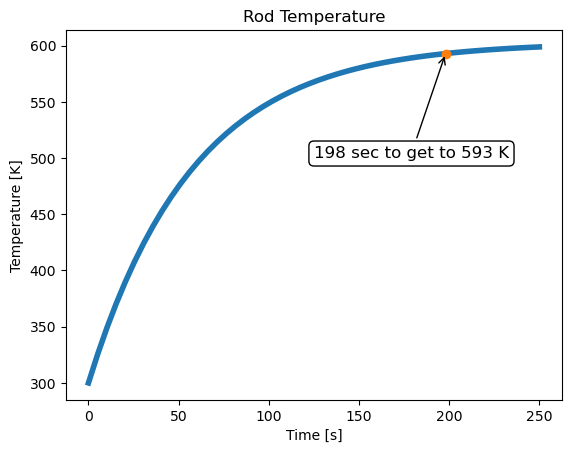

In [3]:
# Part (b) ... transient

# let's pick an "h" from the options above:
h = h_cb

Bi = h*D/4/k
print(f'The Bi = {Bi:0.4f} << 0.1, so lumped capacitance is valid')

# Constants
a = (h * As) / (rho * c * Vol)  # constant, a
qs = 0  # surface heat flux
b = (qs * As + qrod) / (rho * c * Vol)  # constant, b

# Temperature Function
t = linspace(0, 250)  # time space

Temp = (T_inf + (T_i - T_inf) * exp(-a * t) + (b / a) * (1 - exp(-a * t)))
T_ss = (qrod) / (h * As) + T_inf  # steady state soln
print(f'The steady state temperature is Ts = {T_ss:0.0f} K')

T_spec = T_ss - 10  # temp spec: T_s.s. - 1 [K]
t_close = interp(T_spec, Temp, t)  # time at T_spec
print(f'...and it takes {t_close:0.0f} s to get within 10 K of the steady state value')

# Plotting
# fplot(funT,[0 20]); %plots the temperature function from 0 to 20 sec
plt.figure(1)
plt.plot(t, Temp, linewidth=4)  # plots Temp function
plt.plot(t_close, T_spec, 'o', linewidth=5)  # plots target time/Temp
plt.title('Rod Temperature')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [K]')

# Annotation box showing detail on solution point
dim = [0.5, 0.5, 0.3, 0.3]
str = f"{t_close:0.0f} sec to get to {T_spec:0.0f} K"
plt.annotate(str, xy=(t_close, T_spec), xytext=(125, 500), fontsize=12,
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             bbox=dict(boxstyle="round", fc="w"))
plt.show()